# Convex Optimization & Gradient Descent — A Practical Tutorial (NumPy)

This notebook is a **hands-on tutorial** for:
- What **convex optimization** means (convexity, smoothness)
- How to formulate and implement **Gradient Descent (GD)**
- How to choose **step sizes (learning rates)** in practice
- How to **visualize** optimization trajectories and curvature

We will use only:
- **NumPy** for computation
- **Matplotlib** for plotting

> Suggested workflow: run top-to-bottom once, then change the learning rate, conditioning, and starting points.


## 0) Setup

In [1]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def set_seed(seed=0):
    np.random.seed(seed)

print("NumPy version:", np.__version__)


NumPy version: 2.4.1


## 1) Convex optimization: the big picture

A basic optimization problem is
$$
\min_{x\in\mathcal{X}} f(x).
$$

We focus on **unconstrained** problems first $(\mathcal{X}=\mathbb{R}^d)$.

### What makes a problem convex?
- The feasible set $\mathcal{X}$ is **convex** (line segment stays in the set)
- The objective $f$ is **convex**:
$$
f(\theta x + (1-\theta)y) \le \theta f(x) + (1-\theta)f(y),\quad \forall\theta\in[0,1].
$$

### Why does convexity matter?
If $f$ is convex (and differentiable), then:
- any **local minimizer is a global minimizer**
- algorithms like GD have clean convergence guarantees

## 2) Warm-up: a 1D convex quadratic
We start with
$$
f(x)=(x-2)^2,
\quad \nabla f(x)=2(x-2).
$$
GD update:
$$
x_{t+1}=x_t-\eta\nabla f(x_t).
$$
We will compare different step sizes \(\eta\).

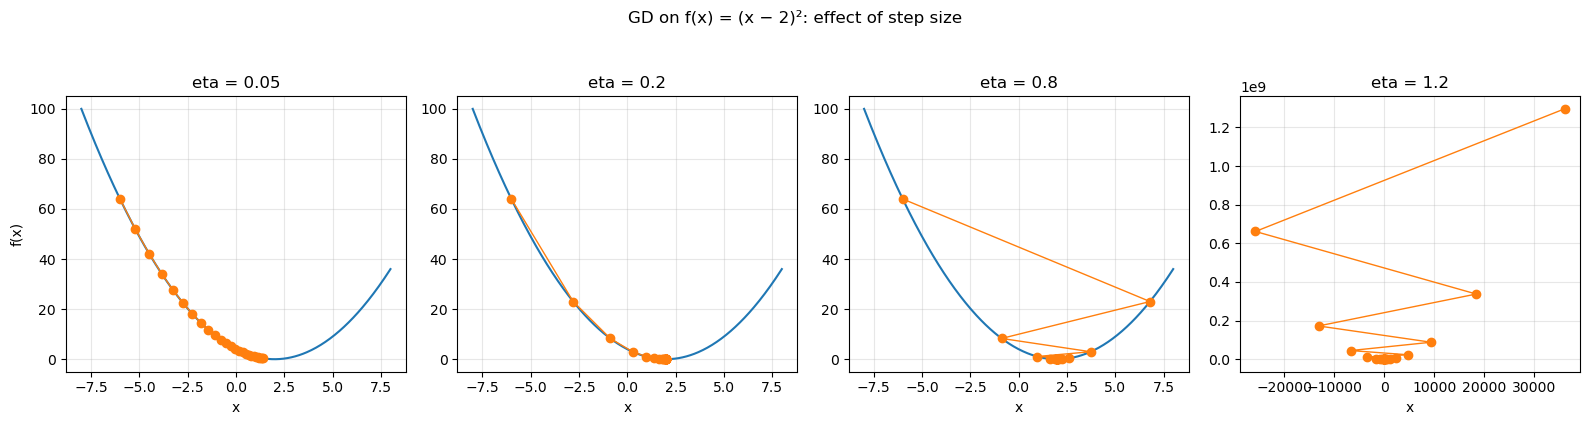

eta=0.05: final x= 1.4257, final f= 0.329842
eta= 0.2: final x= 2.0000, final f= 0.000000
eta= 0.8: final x= 2.0000, final f= 0.000000
eta= 1.2: final x= 36001.0366, final f= 1295930639.344917


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def f1(x):
    return (x - 2.0)**2

def grad_f1(x):
    return 2.0*(x - 2.0)

def gd_1d(x0, eta, T=30):
    xs = [float(x0)]
    for _ in range(T):
        x = xs[-1]
        xs.append(x - eta * grad_f1(x))
    xs = np.array(xs)
    return xs, f1(xs)

x0 = -6.0
etas = [0.05, 0.2, 0.8, 1.2]  # last one intentionally too large
T = 25

xgrid = np.linspace(-8, 8, 400)
ygrid = f1(xgrid)

# Create subplots: share y only among first three
fig = plt.figure(figsize=(16, 4))
gs = fig.add_gridspec(1, 4)

axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1], sharey=axes[0]))
axes.append(fig.add_subplot(gs[0, 2], sharey=axes[0]))
axes.append(fig.add_subplot(gs[0, 3]))  # independent y-scale

for i, (ax, eta) in enumerate(zip(axes, etas)):
    xs, fs = gd_1d(x0, eta, T=T)

    ax.plot(xgrid, ygrid)
    ax.plot(xs, fs, marker="o", linewidth=1)

    ax.set_title(f"eta = {eta}")
    ax.set_xlabel("x")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("f(x)")

fig.suptitle("GD on f(x) = (x − 2)²: effect of step size", y=1.05)
plt.tight_layout()
plt.show()

# Print final results
for eta in etas:
    xs, fs = gd_1d(x0, eta, T=T)
    print(f"eta={eta:>4}: final x={xs[-1]: .4f}, final f={fs[-1]: .6f}")


### A key heuristic for choosing step size $\eta$: smoothness
If $f$ is smooth (meaning its curve looks flat and not very steep), we can choose larger step size $\eta$

## 3) GD in $\mathbb{R}^2$: a convex quadratic bowl

Consider the convex quadratic
$$
f(x)=\tfrac12 x^\top Qx - b^\top x,
$$
where $Q\succ 0$ (positive definite, PD).

Then
$$
\nabla f(x)=Qx-b,\quad x^*=Q^{-1}b.
$$



In [3]:

import numpy as np
import matplotlib.pyplot as plt

Q = np.array([[8.0, 1.5],
              [1.5, 2.0]])   # PD
b = np.array([1.0, 1.0])

def f2(x):
    x = np.asarray(x, dtype=float)
    return 0.5*x.T@Q@x - b.T@x

def grad_f2(x):
    x = np.asarray(x, dtype=float)
    return Q@x - b

x_star = np.linalg.solve(Q, b)
eigvals = np.linalg.eigvalsh(Q)
L = eigvals.max()
mu = eigvals.min()

print("x^* =", x_star, "f(x^*) =", f2(x_star))
print("eigenvalues(Q) =", eigvals, "L =", L, "mu =", mu)


x^* = [0.03636364 0.47272727] f(x^*) = -0.2545454545454545
eigenvalues(Q) = [1.64589803 8.35410197] L = 8.354101966249685 mu = 1.6458980337503153


### 3.1 Implement GD (generic)
We will implement a generic GD routine and visualize trajectories on contour plots.

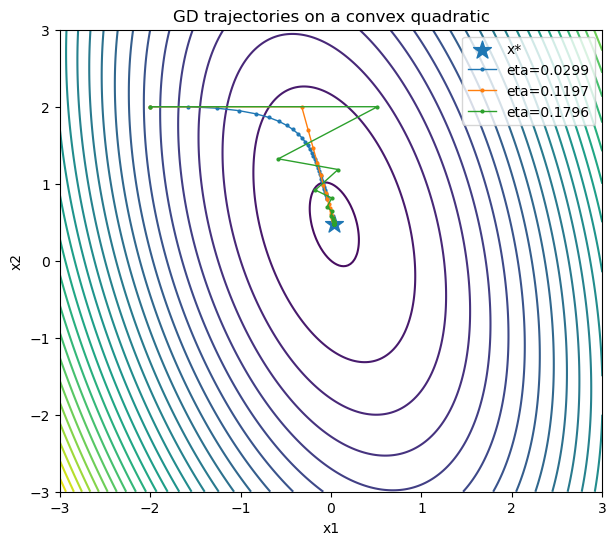

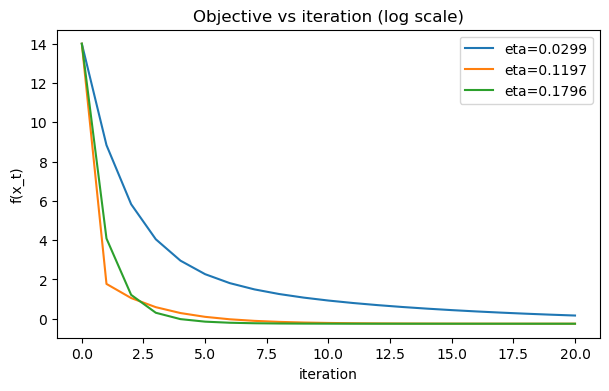

In [4]:

def gradient_descent(f, grad, x0, eta, T=40):
    x = np.asarray(x0, dtype=float).copy()
    xs = [x.copy()]
    fs = [f(x)]
    for _ in range(T):
        x = x - eta * grad(x)
        xs.append(x.copy())
        fs.append(f(x))
    return np.array(xs), np.array(fs)

# contour grid
grid = np.linspace(-3, 3, 240)
X, Y = np.meshgrid(grid, grid)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f2(np.array([X[i, j], Y[i, j]]))

eta_safe = 1.0 / L
etas = [0.25*eta_safe, eta_safe, 1.5*eta_safe]  # last might overshoot depending on Q

x0 = np.array([-2.0, 2.0])

plt.figure(figsize=(7,6))
plt.contour(X, Y, Z, levels=30)
plt.scatter([x_star[0]], [x_star[1]], marker="*", s=180, label="x*")
for eta in etas:
    xs, fs = gradient_descent(f2, grad_f2, x0, eta=eta, T=35)
    plt.plot(xs[:,0], xs[:,1], marker="o", markersize=2, linewidth=1, label=f"eta={eta:.4f}")
plt.title("GD trajectories on a convex quadratic")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
for eta in etas:
    xs, fs = gradient_descent(f2, grad_f2, x0, eta=eta, T=20)
    plt.plot(fs, label=f"eta={eta:.4f}")
# plt.yscale("log")
plt.title("Objective vs iteration (log scale)")
plt.xlabel("iteration")
plt.ylabel("f(x_t)")
plt.legend()
plt.show()


## 4) Step size selection: a practical playbook

### If you can estimate how smooth the objective function is...
For quadratics, smoothness is associated with the largest eigenvalue of $Q$. For general problems, it is harder.

A simple and common approach:
1. start with a conservative choice of $\eta$ (small)
2. if the objective decreases very slowly, increase $\eta$ (e.g., multiply by 2)
3. if the objective explodes / oscillates, decrease $\eta$ (e.g., divide by 2)

### Backtracking line search (optional idea)
One principled method is **backtracking line search**, which shrinks $\eta$ until a sufficient decrease condition holds.
We won't require it in the course, but it is worth knowing.


## 5) Takeaways

### GD algorithm (core)
Given a differentiable objective $f$, GD iterates:
$$
x_{t+1}=x_t-\eta\nabla f(x_t).
$$

### Choosing $\eta$ (practical)
- Start with a small $\eta$
- If the loss diverges: decrease $\eta$.
- If the loss decreases too slowly: increase $\eta$ cautiously.

### Convexity vs nonconvexity
- Convex objectives: no bad local minima; GD behaves predictably.
- Nonconvex objectives: GD may depend on initialization and can get stuck.

